In [192]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
import pandas as pd
from sympy import *
import os

sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

In [193]:
listdir = os.listdir("../StopwatchTimer/")

anton_df = pd.read_table("../StopwatchTimer/pendulanton3.dat", names=["measurement", "TimeAnton"])
ida_df = pd.read_table("../StopwatchTimer/PendulumIda.dat", names=["measurement", "TimeIda"])[:-1]
philip_df = pd.read_table("../StopwatchTimer/PendulumPhilip2.dat", names=["measurement", "TimePhilip"])

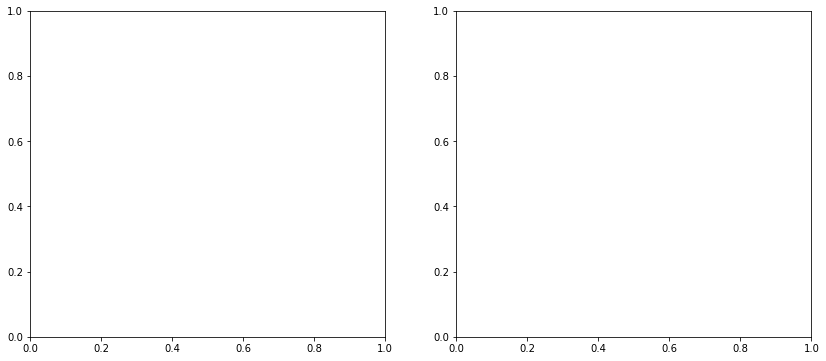

In [194]:
fig, axes = plt.subplots(1, 2, figsize = (14,6), facecolor = "white")

# titles = df.keys()[1:]
# for title, ax in zip(titles, axes):
#     ax.errorbar(df["measurement"], df[title], xerr = 0.5, yerr = 10, ecolor = "k", fmt = ".", color = "k", capsize = 5)
#     ax.set_title(title)
#     ax.set_ylabel("Time (s)")
#     ax.set_xlabel("Measurements")

In [195]:
# fit data to linear function
def linear_function(x, a, b):
    return a * x + b

# Alternatively, you can define Chi2 calculation:
def chi2_owncalc(a, b) :
    y_fit = linear_function(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

errors = [1, 1, 1]

datasetnames = np.array([anton_df, ida_df, philip_df])

array_b = np.zeros(datasetnames.shape)
array_a = np.zeros(datasetnames.shape)
array_b_err = np.zeros(datasetnames.shape)
array_a_err = np.zeros(datasetnames.shape) 
array_Chi2 = np.zeros(datasetnames.shape)
array_Prob = np.zeros(datasetnames.shape)
array_Ndof = np.zeros(datasetnames.shape)

for i, dataframe in enumerate(datasetnames):
    measure, time = dataframe.keys()
    x = dataframe[measure]
    ex = np.zeros_like(x)
    # Note how we include uncertainty in y - by simply adding a Guassian number to the "theoretical value".
    y = dataframe[time]
    ey = errors[i]
    
    chi2_object = Chi2Regression(linear_function, x, y, ey)
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    minuit = Minuit(chi2_object, a=8.5, b=0.0)     # External Functions
    # minuit = Minuit(chi2_owncalc, a=8.5.0, b=0.0)     # Own alternative

    # Perform the actual fit:
    minuit.migrad()

    # Extract the fitting parameters and their errors:
    a_fit = minuit.values['a']
    b_fit = minuit.values['b']
    sigma_a_fit = minuit.errors['a']
    sigma_b_fit = minuit.errors['b']

    Nvar = 2                     # Number of variables (alpha0 and alpha1)
    Ndof_fit = len(x) - Nvar   # Number of degrees of freedom = Number of data points - Number of variables

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    # Fill the arrays with fit results (to produce plots of these at the end):
    array_Ndof[i] = Ndof_fit
    array_a_err[i] = sigma_a_fit
    array_b_err[i] = sigma_b_fit
    array_a[i] = a_fit
    array_b[i] = b_fit
    array_Chi2[i] = Chi2_fit
    array_Prob[i] = Prob_fit

print(array_b, array_a, array_Chi2, array_Prob)


[ 0.43805379  2.15481208 -4.40269829] [8.60231965 8.60687498 8.60883029] [0.4079453  0.1570173  0.15405263] [1. 1. 1.]


C:\Users\phili\AppData\Local\Temp/ipykernel_18796/2119270250.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datasetnames = np.array([anton_df, ida_df, philip_df])


In [196]:
for a, b, dataframe in zip(array_a, array_b, datasetnames):
    measure, time = dataframe.keys()
    dataframe["residual"] = dataframe[time] - np.array(linear_function(dataframe[measure], a, b)).T

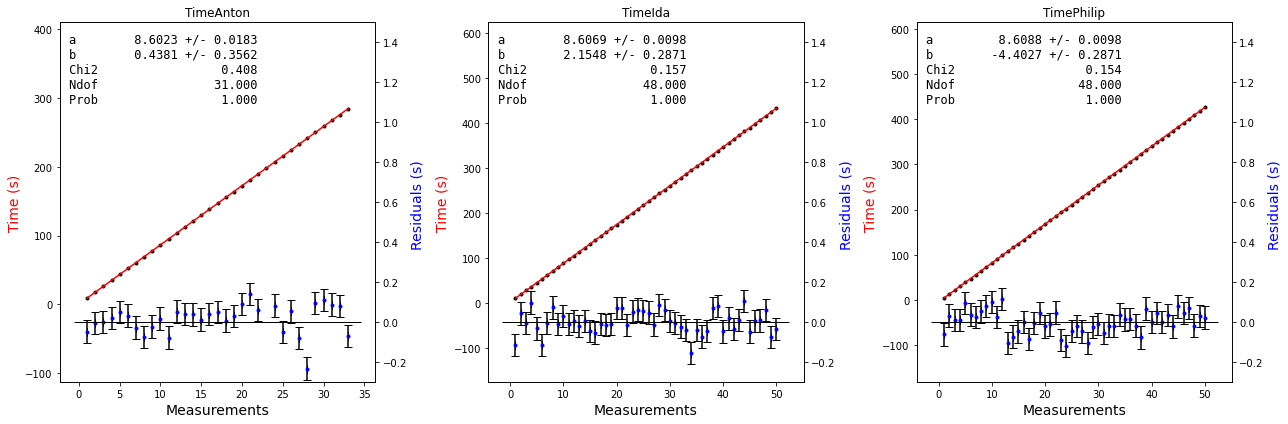

In [197]:
N_datasets = len(datasetnames)

fig, axes = plt.subplots(1, N_datasets, figsize = (18,6), facecolor = "white", sharex = False)

for dataframe, ax, i in zip(datasetnames, axes, range(N_datasets)):
    measure, time, res = dataframe.keys()
    ax.errorbar(dataframe[measure], dataframe[time], xerr = 0, yerr = 1, ecolor = "k", fmt = ".", color = "k", capsize = 0, zorder = 0)
    ax.plot(dataframe[measure], linear_function(dataframe[measure], array_a[i], array_b[i]), color = "r", linewidth = 1.5)
    ylim = np.array(ax.get_ylim())
    ylim[0] = ylim[0] - np.diff(ylim)*0.35
    ylim[1] = ylim[1]*1.37
    ax.set_ylim(*ylim)
    ax.set_title(time)
    ax.set_ylabel("Time (s)", color = "r", fontsize = 14)
    ax.set_xlabel("Measurements", color = "k", fontsize = 14)
    
    sec_ax = ax.twinx()
    sec_ax.errorbar(dataframe[measure], dataframe[res], xerr = 0, yerr = 0.056, ecolor = "k", fmt = ".", color = "b", capsize = 4, zorder = 0)
    sec_ax.set_ylim(-0.3,1.5)
    sec_ax.set_ylabel("Residuals (s) ", color = "b", fontsize = 14)
    xlim = ax.get_xlim()
    sec_ax.hlines(0, *xlim, color = "k", linewidth = 1)
    
    d = {
         "a": f"{array_a[i]:.4f} +/- {array_a_err[i]:.4f}",
         "b": f"{array_b[i]:.4f} +/- {array_b_err[i]:.4f}",
         "Chi2": array_Chi2[i],
         "Ndof": array_Ndof[i],
         "Prob": array_Prob[i]
         }
    
    text = nice_string_output(d)
    add_text_to_ax(0.03, 0.97, text, ax)
    
fig.tight_layout()
plt.show()

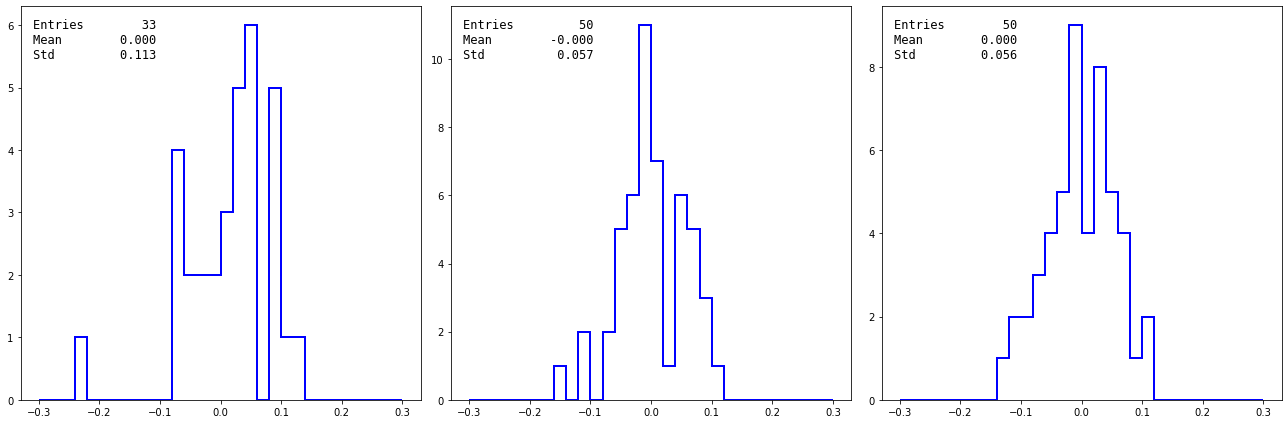

In [198]:
fig, axes = plt.subplots(1, N_datasets, figsize = (18,6), facecolor = "white", sharex = False)

for dataframe, ax in zip(datasetnames, axes):
    measure, time, res = dataframe.keys()
    ax.hist(dataframe[res], bins = 30, histtype = "step", linewidth = 2, color ="b", range = (-0.3, 0.3))
    add_header_to_ax(dataframe[res], 0.03, 0.97, ax)
fig.tight_layout()



In [199]:
# fit data to linear function
def linear_function(x, a, b):
    return a * x + b

# Alternatively, you can define Chi2 calculation:
def chi2_owncalc(a, b) :
    y_fit = linear_function(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

errors =[np.std(dataframe["residual"], ddof = 1) for dataframe in datasetnames]

datasetnames = np.array([anton_df, ida_df, philip_df])

array_b = np.zeros(datasetnames.shape)
array_a = np.zeros(datasetnames.shape)
array_b_err = np.zeros(datasetnames.shape)
array_a_err = np.zeros(datasetnames.shape) 
array_Chi2 = np.zeros(datasetnames.shape)
array_Prob = np.zeros(datasetnames.shape)
array_Ndof = np.zeros(datasetnames.shape)

for i, dataframe in enumerate(datasetnames):
    measure, time, res = dataframe.keys()
    x = dataframe[measure]
    ex = np.zeros_like(x)
    # Note how we include uncertainty in y - by simply adding a Guassian number to the "theoretical value".
    y = dataframe[time]
    ey = errors[i]
    
    chi2_object = Chi2Regression(linear_function, x, y, ey)
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    minuit = Minuit(chi2_object, a=8.5, b=0.0)     # External Functions
    # minuit = Minuit(chi2_owncalc, a=8.5.0, b=0.0)     # Own alternative

    # Perform the actual fit:
    minuit.migrad()

    # Extract the fitting parameters and their errors:
    a_fit = minuit.values['a']
    b_fit = minuit.values['b']
    sigma_a_fit = minuit.errors['a']
    sigma_b_fit = minuit.errors['b']

    Nvar = 2                     # Number of variables (alpha0 and alpha1)
    Ndof_fit = len(x) - Nvar   # Number of degrees of freedom = Number of data points - Number of variables

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    # Fill the arrays with fit results (to produce plots of these at the end):
    array_Ndof[i] = Ndof_fit
    array_a_err[i] = sigma_a_fit
    array_b_err[i] = sigma_b_fit
    array_a[i] = a_fit
    array_b[i] = b_fit
    array_Chi2[i] = Chi2_fit
    array_Prob[i] = Prob_fit

print(array_b, array_a, array_Chi2, array_Prob)

[ 0.43805379  2.15481208 -4.40269829] [8.60231965 8.60687498 8.60883029] [32. 49. 49.] [0.41674403 0.4327594  0.4327594 ]


C:\Users\phili\AppData\Local\Temp/ipykernel_18796/1999508604.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datasetnames = np.array([anton_df, ida_df, philip_df])


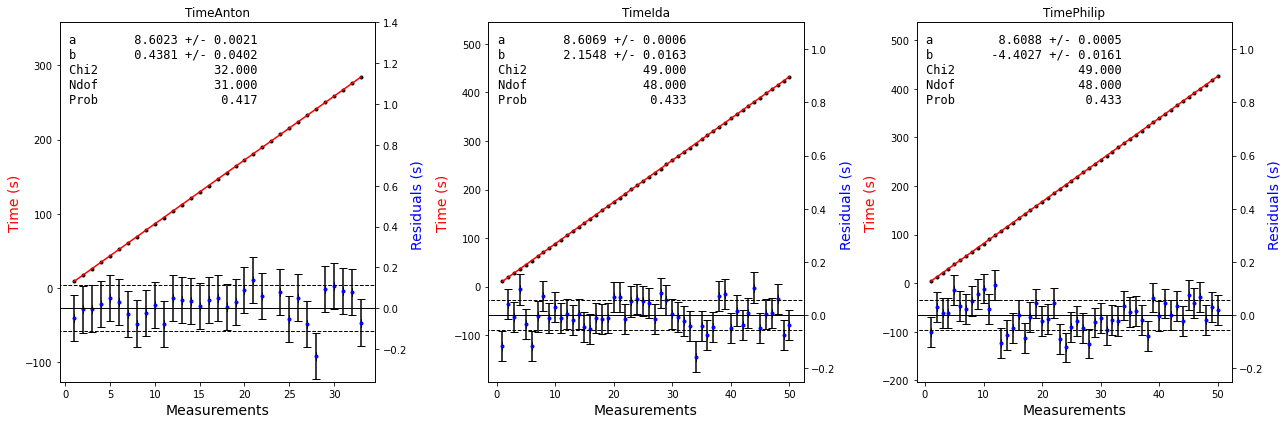

In [200]:
fig, axes = plt.subplots(1, N_datasets, figsize = (18,6), facecolor = "white", sharex = False)

ylims = [(-0.36,1.4), (-0.25,1.1), (-0.25,1.1)]

for dataframe, ax, i in zip(datasetnames, axes, range(N_datasets)):
    measure, time, res = dataframe.keys()
    ax.errorbar(dataframe[measure], dataframe[time], xerr = 0, yerr = errors[i], ecolor = "k", fmt = ".", color = "k", capsize = 0, zorder = 0)
    ax.plot(dataframe[measure], linear_function(dataframe[measure], array_a[i], array_b[i]), color = "r", linewidth = 1.5)
    ylim = np.array(ax.get_ylim())
    ylim[0] = ylim[0] - np.diff(ylim)*0.4
    ylim[1] = ylim[1]*1.2
    ax.set_ylim(*ylim)
    ax.set_title(time)
    ax.set_ylabel("Time (s)", color = "r", fontsize = 14)
    ax.set_xlabel("Measurements", color = "k", fontsize = 14)
    
    sec_ax = ax.twinx()
    sec_ax.errorbar(dataframe[measure], dataframe[res], xerr = 0, yerr = errors[i], ecolor = "k", fmt = ".", color = "b", capsize = 4, zorder = 0)
    sec_ax.set_ylim(*ylims[i])
    sec_ax.set_ylabel("Residuals (s) ", color = "b", fontsize = 14)
    xlim = np.array(ax.get_xlim())
    ax.set_xlim(*xlim)
    xlim[0] = xlim[0] - 5
    xlim[1] = xlim[1] + 5
    sec_ax.hlines(0, *xlim, color = "k", linewidth = 1)
    sec_ax.hlines(errors[i], *xlim, color = "k", linewidth = 1, linestyle = "--")
    sec_ax.hlines(-errors[i], *xlim, color = "k", linewidth = 1, linestyle = "--")
    
    d = {
         "a": f"{array_a[i]:.4f} +/- {array_a_err[i]:.4f}",
         "b": f"{array_b[i]:.4f} +/- {array_b_err[i]:.4f}",
         "Chi2": array_Chi2[i],
         "Ndof": array_Ndof[i],
         "Prob": array_Prob[i]
         }
    
    text = nice_string_output(d)
    add_text_to_ax(0.03, 0.97, text, ax)
    
fig.tight_layout()
plt.show()

In [ ]:
def weighted_mean(x, sigmax):
    return np.sum(x / sigmax**2) / np.sum(1 / sigmax ** 2)
print(anton_df["TimeAnton"].shape)
zeroed_t = []
for dataframe in datasetnames:
    me, t, res = dataframe.keys()
    zeroed_t.append((dataframe[t] - dataframe[t][0]).to_list())
    
weight


In [ ]:
weighted_t = []

In [201]:
pend = pd.read_csv("./Pendulumparameterright.csv", delimiter=';', decimal=',')
print(pend.keys())
display(pend)

Index(['Pendulum to top (m)', 'Pendulum to top error (m)', 'Floor to top (m)',
       'Floor to top (m).1', 'Pendulum height (cm)',
       'Pendulum height error (cm)', 'Floor to pendulum laser (m)',
       'Floor to pendulum laser error (m)',
       'Floor to pendulum measuring tape (cm)',
       'Floor to pendulum measuring tape error (cm)',
       'Floor to attic laser (m)', 'Floor to attic laser error (m)'],
      dtype='object')


,Pendulum to top (m),Pendulum to top error (m),Floor to top (m),Floor to top (m).1,Pendulum height (cm),Pendulum height error (cm),Floor to pendulum laser (m),Floor to pendulum laser error (m),Floor to pendulum measuring tape (cm),Floor to pendulum measuring tape error (cm),Floor to attic laser (m),Floor to attic laser error (m)
0,18.10,0.01,18.760,0.015,3.01,0.05,0.310,0.001,31.1,0.1,18.775,0.001
1,18.15,0.50,18.600,0.500,3.02,0.02,0.311,0.001,31.0,0.1,18.784,0.001
2,18.42,0.20,18.743,0.200,3.01,0.03,0.310,0.001,31.1,0.1,18.830,0.001


In [233]:
L_Laser = np.mean(pend['Floor to attic laser (m)'][:-1]) - np.mean(pend["Floor to pendulum laser (m)"]) - np.mean(pend["Pendulum height (cm)"]/100/2)
L_Laser_err = np.sqrt(np.std(pend['Floor to attic laser (m)'])**2 + np.std(pend["Floor to pendulum laser (m)"])**2 + np.std(pend["Pendulum height (cm)"]/100) **2 )
print(L_Laser, L_Laser_err)

18.4541 0.02409246078479028


In [234]:
g_laser = L_Laser * (2 * np.pi / array_a) ** 2
print(g_laser)

[9.84512996 9.83471134 9.83024437]


In [204]:
L = Symbol("L")
T = Symbol("T")

g = L * (2 * np.pi / T) ** 2

g_sigma_L_con = lambdify([L, T], g.diff(L)**2 * L_Laser_err**2, 'numpy')(L_Laser, array_a)
g_sigma_T_con = lambdify([L, T], g.diff(T)**2 * array_a_err**2, "numpy")(L_Laser, array_a)
print(g_sigma_L_con, g_sigma_T_con)
print(g_sigma_L_con + g_sigma_T_con)

[0.0001652  0.00016485 0.0001647 ] [array([2.23642189e-05, 2.22932931e-05, 2.22629297e-05]), array([1.61532550e-06, 1.61020266e-06, 1.60800957e-06]), array([1.58482801e-06, 1.57980189e-06, 1.57765021e-06])]
[[0.00018757 0.00018715 0.00018697]
 [0.00016682 0.00016646 0.00016631]
 [0.00016679 0.00016643 0.00016628]]


0.007058823529411765
0    1.28
1    0.09
2    0.52
3   -0.76
4   -0.18
dtype: float64


(array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.]),
 array([-0.76 , -0.556, -0.352, -0.148,  0.056,  0.26 ,  0.464,  0.668,
         0.872,  1.076,  1.28 ]),
 <BarContainer object of 10 artists>)

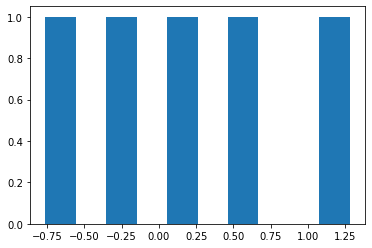

In [205]:
def weighted_mean(x, sigmax):
    return np.sum(x / sigmax**2) / np.sum(1 / sigmax ** 2)

def weighted_std(sigmax):
    return np.sqrt(1 / np.sum(1 / sigmax ** 2))

L_mean = weighted_mean(fake_data["L"], fake_data["Lerr"])
L_std = weighted_std(fake_data["Lerr"])
print(L_std)
z = (fake_data["L"] - np.mean(fake_data["L"])) / fake_data["Lerr"]
print(z)
plt.hist(z)

In [206]:
from sympy import *

In [207]:
L = Symbol("L")
T = Symbol("T")

g = L * (2 * np.pi / T) ** 2

g_sigma_L_con = lambdify([L, T], g.diff(L)**2 * L_std**2, 'numpy')(L_mean, array_a[0])
g_sigma_T_con = lambdify([L, T], g.diff(T)**2 * array_a_err[0]**2, "numpy")(L_mean, array_a[0])
print(g_sigma_L_con, g_sigma_T_con)
print(g_sigma_L_con + g_sigma_T_con)


1.418148850067962e-05 1.2857834061558611e-05
2.703932256223823e-05
